###########################################################################<br>
\# This code is associated to the paper:<br>
\# <b>Provable bounds for noise-free expectation values computed from noisy samples</b><br>
\# (https://arxiv.org/abs/2312.00733)<br>
\# <br>
\# (C) Copyright IBM 2024.<br>
\# <br>
\# Any modifications or derivative works of this code must retain<br>
\# this copyright notice, and modified files need to carry a notice<br>
\# indicating that they have been altered from the originals.<br>
###########################################################################

# 40-qubit QAOA

QAOA for maxcut on random 3-regular graph with 40 nodes presented in https://arxiv.org/abs/2312.00733.

Original source of graph and circuit: 
- [1] Paper: "Large-scale quantum approximate optimization on non-planar graphs with machine learning noise mitigation", [arXiv:2307.14427](https://arxiv.org/abs/2307.14427) (2023). 
- [2] Repository: https://github.com/eggerdj/large_scale_qaoa

This notebook contains the code for:
- [Figure 1](#Figure-1)
- [Table 1](#Table-1)

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile, qpy
from qiskit.transpiler import PassManager
from qiskit.circuit.library import XGate, YGate

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler, Session, Options

from qiskit_ibm_provider.transpiler.passes.scheduling import (DynamicCircuitInstructionDurations, 
                                                              ALAPScheduleAnalysis, 
                                                              PadDynamicalDecoupling, 
                                                              PadDelay)

from qiskit_optimization.applications import Maxcut

In [2]:
# optimal solution
opt_val = 56

# noise-free QAOA expectation values evaluated via lightcone optimization (cf. original source [1])
# p = 1, 2
noise_free_exp_vals = [41.5165, 45.2717]

In [3]:
# load graph
graph = json.load(open('./data/graph_7layers_8seed.json'))
problem = Maxcut(graph['Original graph'])
qp = problem.to_quadratic_program()

# define Maxcut objective
def objective(x):
    return qp.objective.evaluate([int(b) for b in reversed(x)])

In [4]:
# load circuits
with open('./data/circuits_40_qubits.qpy', 'rb') as f:
    qcs = qpy.load(f)

In [5]:
# instantiate Qiskit runtime service
service = QiskitRuntimeService(channel='ibm_quantum')

In [6]:
# select backend
# backend = service.backend('ibm_sherbrooke')
backend = service.backend('ibm_kyiv')

# Initial layout and layer fidelity

The initial layout and layer fidelities can be evaluated using the corresponding Qiskit Experiment provided here:
1. Qiskit Experiments: https://github.com/Qiskit-Extensions/qiskit-experiments/pull/1322
2. Tutorial: https://github.com/qiskit-community/qiskit-device-benchmarking/pull/1

Tutorial in 2 can be adjusted to determine best 40 qubits and return corresponding layer fidelities of pairwise CNOTs on qubits $(2*i, 2*i+1)$ as well as $(2*i+1, 2*i+2)$ for suitable $i$.

In [7]:
initial_layout = [23, 22, 21, 20, 19, 18, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 
                  16, 26, 25, 24, 34, 43, 42, 41, 53, 60, 61, 62, 72,
                  81, 82, 83, 92, 102, 101, 100, 110, 118, 117, 116]

In [8]:
# derived from layer fidelity experiment
lf_1 = 0.787
lf_2 = 0.777
lf = lf_1 * lf_2
cnot_fidelity = lf**(1/39)
gamma_cnot = 1/cnot_fidelity**2
print('gamma_cnot:', gamma_cnot)

gamma_cnot: 1.0255434472974303


# Transpile circuits

In [9]:
# set whether to transpile circuits or pre-load already transpiled circuits.
# transpilation can take a few hours
transpile_circuits = False

## Apply Pauli twirling

In [10]:
"""
Transpiler Pass for Pauli Twirling
Source: https://docs.quantum.ibm.com/transpile/custom-transpiler-pass
"""

from qiskit.dagcircuit import DAGCircuit
from qiskit.circuit import QuantumCircuit, QuantumRegister, Gate
from qiskit.circuit.library import CXGate, ECRGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.quantum_info import Operator, pauli_basis
 
import numpy as np
 
from typing import Iterable, Optional


class PauliTwirl(TransformationPass):
    """Add Pauli twirls to two-qubit gates."""
 
    def __init__(
        self,
        gates_to_twirl: Optional[Iterable[Gate]] = None,
    ):
        """
        Args:
            gates_to_twirl: Names of gates to twirl. The default behavior is to twirl all
                two-qubit basis gates, `cx` and `ecr` for IBM backends.
        """
        if gates_to_twirl is None:
            gates_to_twirl = [CXGate(), ECRGate()]
        self.gates_to_twirl = gates_to_twirl
        self.build_twirl_set()
        super().__init__()
 
    def build_twirl_set(self):
        """
        Build a set of Paulis to twirl for each gate and store internally as .twirl_set.
        """
        self.twirl_set = {}
 
        # iterate through gates to be twirled
        for twirl_gate in self.gates_to_twirl:
            twirl_list = []
 
            # iterate through Paulis on left of gate to twirl
            for pauli_left in pauli_basis(2):
 
                # iterature through Paulis on right of gate to twirl
                for pauli_right in pauli_basis(2):
 
                    # save pairs that produce identical operation as gate to twirl
                    if (Operator(pauli_left) @ Operator(twirl_gate)).equiv(Operator(twirl_gate) @ pauli_right):
                        twirl_list.append((pauli_left, pauli_right))
 
            self.twirl_set[twirl_gate.name] = twirl_list
 
    def run(
        self,
        dag: DAGCircuit,
    ) -> DAGCircuit:
 
        # collect all nodes in DAG and proceed if it is to be twirled
        twirling_gate_classes = tuple(gate.base_class for gate in self.gates_to_twirl)
        for node in dag.op_nodes():
            if not isinstance(node.op, twirling_gate_classes):
                continue
 
            # random integer to select Pauli twirl pair
            pidx = np.random.randint(0, len(self.twirl_set[node.op.name]),)
            twirl_pair = self.twirl_set[node.op.name][pidx]
 
            # instantiate mini_dag and attach quantum register
            mini_dag = DAGCircuit()
            register = QuantumRegister(2)
            mini_dag.add_qreg(register)
 
            # apply left Pauli, gate to twirl, and right Pauli to empty mini-DAG
            mini_dag.apply_operation_back(twirl_pair[0].to_instruction(), [register[0], register[1]])
            mini_dag.apply_operation_back(node.op, [register[0], register[1]])
            mini_dag.apply_operation_back(twirl_pair[1].to_instruction(), [register[0], register[1]])
 
            # substitute gate to twirl node with twirling mini-DAG
            dag.substitute_node_with_dag(node, mini_dag)
 
        return dag

In [11]:
# set number of twirls
num_twirls = 20

if transpile_circuits:
    pm_twirl = PassManager([PauliTwirl()])
    twirled_qcs = [[], []]
    for i, qc in enumerate(qcs):
        twirled_qcs[i] += [pm_twirl.run(qc) for _ in range(num_twirls)]

## Apply dynamic decoupling

In [12]:
if transpile_circuits:
    # transpile circuits to backend
    transpiled_circs = [[], []]
    for i, tqcs in enumerate(twirled_qcs):
        transpiled_circs[i] += transpile(tqcs, backend, initial_layout=initial_layout, optimization_level=0)

In [13]:
# prepare dynamic decoupling transpiler passes
durations =  DynamicCircuitInstructionDurations.from_backend(backend)
dd_sequence = [XGate(), XGate()]
coupling_map = backend.coupling_map
pm = PassManager(
  [
      ALAPScheduleAnalysis(durations),
      PadDynamicalDecoupling(durations, dd_sequence, coupling_map=coupling_map),
  ]
)

# XYXY sequence
spacings = [0.125, 0.25, 0.25, 0.25, 0.125] 
alt_spacings = [0.25, 0.25, 0.25, 0.25, 0]
decoupling_seq = [XGate(), YGate(), XGate(), YGate()]

# set y durations to be equal to x durations since backend does not report y durations
durations.update([('y', i, durations.get('x', i)) for i in range(backend.num_qubits)])

min_seq_ratio = 1

pm_dd = PassManager([
    ALAPScheduleAnalysis(durations),
    PadDynamicalDecoupling(durations, decoupling_seq, coupling_map=coupling_map, spacings=spacings,
                           alt_spacings=alt_spacings, sequence_min_length_ratios=min_seq_ratio)
                                   ])

In [14]:
final_circs = [[], []]
if transpile_circuits:
    for i, tqcs in enumerate(transpiled_circs):
        for j, transpiled_circ in enumerate(tqcs):
            final_circ = pm_dd.run(transpiled_circ)
            final_circ = transpile(final_circ, backend, optimization_level=0)
            final_circs[i].append(final_circ)
else:
    # load final transpiled circuits
    for i in range(len(qcs)):
        with open(f'./results/final_circs_{backend.name}_p_{i+1}.qpy', 'rb') as f:
            final_circs[i] = qpy.load(f)

In [15]:
if transpile_circuits:
    for i in range(len(qcs)):
        with open(f'./results/final_circs_{backend.name}_p_{i+1}.qpy', 'wb') as f:
            qpy.dump(final_circs[i], f)

# Run circuits

## Run p=1 circuit

Run with 100k shots, which is the maximum the API allows.

In [16]:
# prepare sampler
options = Options(optimization_level=0)
options.resilience_level = 0
options.execution.shots = 100_000 // num_twirls
options.transpilation.skip_transpilation=True

sampler = Sampler(options=options, backend=backend)

In [17]:
# determine whether to run circuits or load pre-run results
run_circuits_1 = False

In [18]:
if run_circuits_1:
    job_1 = sampler.run(final_circs[0])

In [19]:
if run_circuits_1:
    print(job_1.job_id())

In [20]:
if run_circuits_1:
    print(job_1.status())

In [21]:
if run_circuits_1:
    result_1 = job_1.result()

In [22]:
if run_circuits_1:
    
    # extract probabilities and values
    probs_1 = []
    values_1 = []
    # combine results from different twirls
    for i in range(len(final_circs[0])):
        for b, p in result_1.quasi_dists[i].binary_probabilities().items():
            probs_1 += [p]
            values_1 += [objective(b)]
    probs_1 = np.array(probs_1)/len(final_circs[0])
    values_1 = np.array(values_1)
    idx = np.argsort(values_1)
    probs_1 = probs_1[idx]
    values_1 = values_1[idx]

In [23]:
# overwrite pre-run results if circuits have been re-ran
if run_circuits_1:
    np.save(f'results/probs_{backend.name}_p1.npy', probs_1)
    np.save(f'results/values_{backend.name}_p1.npy', values_1)

### Load pre-computed p=1 results

In [24]:
# load pre-run results if circuits have not been re-ran
if not run_circuits_1:
    probs_1 = np.load(f'results/probs_{backend.name}_p1.npy')
    values_1 = np.load(f'results/values_{backend.name}_p1.npy')

### plot p=1 results with 100k shots

In [25]:
# number comes from layer fidelity experiment
num_cnots_1 = qcs[0].count_ops()['cx']
sqrt_gamma_1 = gamma_cnot**(num_cnots_1/2)
alpha_1 = 1/sqrt_gamma_1

k = int(np.ceil(alpha_1*1e5))+1
cvar_gamma_1 = np.mean(values_1[-k:])

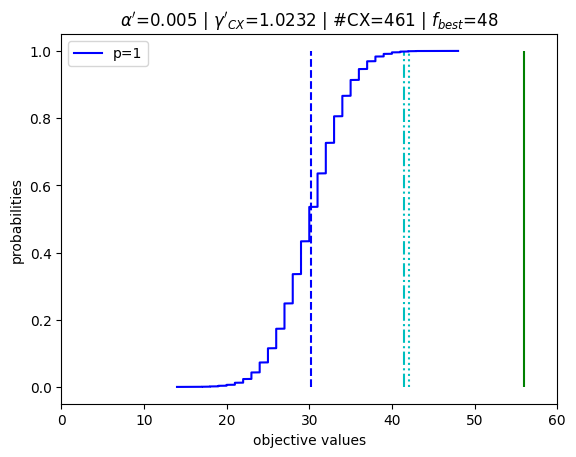

In [26]:
cum_probs_1 = np.cumsum(probs_1)
rev_cum_probs_1 = np.cumsum(probs_1[::-1])

j = 1
while (values_1[-j:]@probs_1[-j:])/rev_cum_probs_1[j-1] > noise_free_exp_vals[0]:
    j += 1
alpha_1_ = cum_probs_1[j-2]  # alpha' = fitted so CVaR matches expectation value

best_val_1 = np.max(values_1)

gamma_1_ = 1/alpha_1_**2
gamma_cnot_1_ = gamma_1_**(1/num_cnots_1)

mean_1 = values_1 @ probs_1

plt.title(rf"$\alpha'$={np.round(alpha_1_, decimals=4)} | $\gamma'_{{CX}}$={np.round(gamma_cnot_1_, decimals=4)} | #CX={num_cnots_1} | $f_{{best}}$={int(best_val_1)}")

plt.vlines(opt_val, 0, 1, 'g')
plt.vlines(noise_free_exp_vals[0], 0, 1, 'c', linestyles='-.')
plt.vlines(cvar_gamma_1, 0, 1, 'c', linestyles=':')
plt.plot(values_1, cum_probs_1, 'b', label=f'p={1}')
plt.vlines(mean_1, 0, 1, 'b', linestyles='--')

plt.xlim(0, 60)
plt.legend(loc='upper left')

plt.ylabel('probabilities')
plt.xlabel('objective values')

plt.show()

## Run p=2 circuit

Run with 10M shots, which needs to be split into 5 jobs with 20 circuits each and 100k shots per circuit due to the maximum number of shots per circuit of 100k.

In [27]:
# prepare sampler
options = Options(optimization_level=0)
options.resilience_level = 0
options.execution.shots = 100_000
options.transpilation.skip_transpilation=True

sampler = Sampler(options=options, backend=backend)

In [28]:
# determine whether to run circuits or load pre-run results
run_circuits_2 = False

In [29]:
if run_circuits_2:

    num_jobs = 5

    jobs = []
    for i in range(num_jobs):
        job = sampler.run(final_circs[1])
        jobs += [job]

In [30]:
if run_circuits_2:
    for job in jobs:
        print(job.status())

In [31]:
if run_circuits_2:
    batch_results = []
    for job in jobs:
        batch_results += [job.result()]

In [32]:
if run_circuits_2:
    probs_2 = []
    values_2 = []
    for result in batch_results:
        for i in range(len(final_circs[1])):
            for b, p in result.quasi_dists[i].binary_probabilities().items():
                probs_2 += [p]
                values_2 += [objective(b)]

In [33]:
if run_circuits_2:
    probs_2 = np.array(probs_2)/len(final_circs[1])/num_jobs
    values_2 = np.array(values_2)
    idx = np.argsort(values_2)
    probs_2 = probs_2[idx]
    values_2 = values_2[idx]

In [34]:
# save results if circuits have been re-run
if run_circuits_2:
    np.save(f'results/probs_{backend.name}_p2.npy', probs_2)
    np.save(f'results/values_{backend.name}_p2.npy', values_2)

### Load pre-computed p=2 results

In [35]:
# load pre-ran results if circuits are not run
if not run_circuits_2:
    probs_2 = np.load(f'results/probs_{backend.name}_p2.npy')
    values_2 = np.load(f'results/values_{backend.name}_p2.npy')

### Plot p=2 results with 10M shots

In [36]:
# number comes from layer fidelity experiment
num_cnots_2 = qcs[1].count_ops()['cx']
sqrt_gamma_2 = gamma_cnot**(num_cnots_2/2)
alpha_2 = 1/sqrt_gamma_2

k = int(np.ceil(alpha_2*1e7))+1
cvar_gamma_2 = np.mean(values_2[-k:])

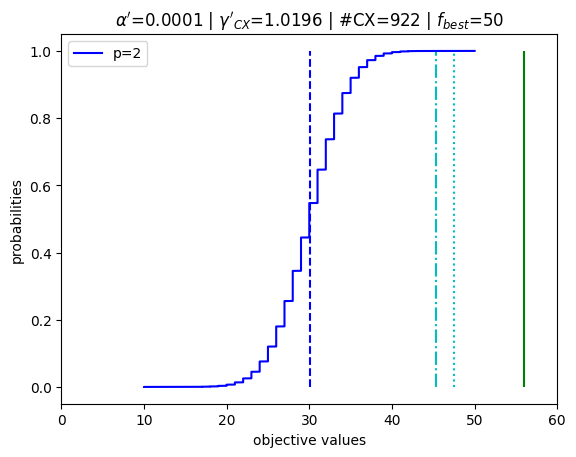

In [37]:
cum_probs_2 = np.cumsum(probs_2)
rev_cum_probs_2 = np.cumsum(probs_2[::-1])

j = 1
while (values_2[-j:]@probs_2[-j:])/rev_cum_probs_2[j-1] > noise_free_exp_vals[1]:
    j += 1
alpha_2_ = cum_probs_2[j-2]

best_val_2 = np.max(values_2)
gamma_2_ = 1/alpha_2_**2
gamma_cnot_2_ = gamma_2_**(1/num_cnots_2)
mean_2 = values_2 @ probs_2

plt.title(rf"$\alpha'$={np.round(alpha_2_, decimals=4)} | $\gamma'_{{CX}}$={np.round(gamma_cnot_2_, decimals=4)} | #CX={num_cnots_2} | $f_{{best}}$={int(best_val_2)}")
plt.vlines(opt_val, 0, 1, 'g')
plt.vlines(noise_free_exp_vals[1], 0, 1, 'c', linestyles='-.')
plt.vlines(cvar_gamma_2, 0, 1, 'c', linestyles=':')
plt.plot(values_2, cum_probs_2, 'b', label=f'p={2}')
plt.vlines(mean_2, 0, 1, 'b', linestyles='--')
plt.xlim(0, 60)
plt.legend(loc='upper left')
plt.ylabel('probabilities')
plt.xlabel('objective values')
plt.show()

# Figure 1

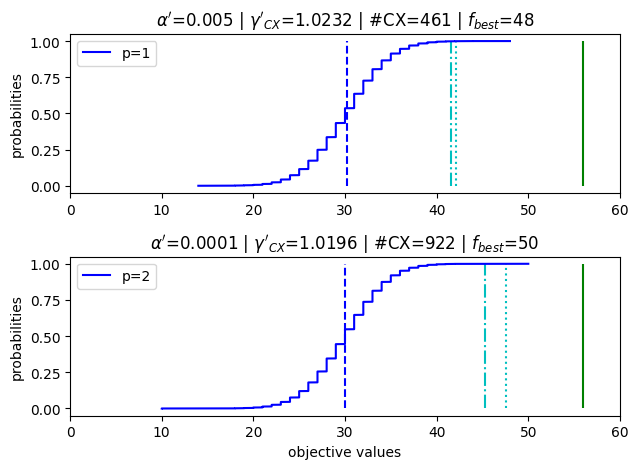

In [38]:
plt.subplots(2,1)

# p = 1
plt.subplot(2,1,1)
plt.title(rf"$\alpha'$={np.round(alpha_1_, decimals=4)} | $\gamma'_{{CX}}$={np.round(gamma_cnot_1_, decimals=4)} | #CX={num_cnots_1} | $f_{{best}}$={int(best_val_1)}")
plt.vlines(opt_val, 0, 1, 'g')
plt.vlines(noise_free_exp_vals[0], 0, 1, 'c', linestyles='-.')
plt.vlines(cvar_gamma_1, 0, 1, 'c', linestyles=':')
plt.plot(values_1, cum_probs_1, 'b', label=f'p={1}')
plt.vlines(mean_1, 0, 1, 'b', linestyles='--')
plt.xlim(0, 60)
plt.legend(loc='upper left')
plt.ylabel('probabilities')

# p = 2
plt.subplot(2,1,2)
plt.title(rf"$\alpha'$={np.round(alpha_2_, decimals=4)} | $\gamma'_{{CX}}$={np.round(gamma_cnot_2_, decimals=4)} | #CX={num_cnots_2} | $f_{{best}}$={int(best_val_2)}")
plt.vlines(opt_val, 0, 1, 'g')
plt.vlines(noise_free_exp_vals[1], 0, 1, 'c', linestyles='-.')
plt.vlines(cvar_gamma_2, 0, 1, 'c', linestyles=':')
plt.plot(values_2, cum_probs_2, 'b', label=f'p={2}')
plt.vlines(mean_2, 0, 1, 'b', linestyles='--')
plt.xlim(0, 60)
plt.legend(loc='upper left')
plt.ylabel('probabilities')
plt.xlabel('objective values')

plt.tight_layout()
plt.savefig(f'results/figure_1_{backend.name}.pdf')
plt.show()

# Table 1

In [39]:
def npr(x, d=3):
    return np.round(x, decimals=d)

print('==============================')
print('global optimum:  ', opt_val)
print('gamma_cnot:      ', npr(gamma_cnot, 4))
print('==============================')
print('p=1')
print('==============================')
print('noisy mean:      ', npr(mean_1))
print('noise-free mean: ', npr(noise_free_exp_vals[0]))
print('CVaR_alpha:      ', npr(cvar_gamma_1))
print('best sample:     ', best_val_1)
print('------------------------------')
print('#CNOTs:          ', npr(num_cnots_1, 4))
print('sqrt(gamma):     ', npr(sqrt_gamma_1))
print('alpha:           ', npr(alpha_1, 8))
print('alpha_prime:     ', npr(alpha_1_, 8))
print('gamma_cnot_prime:', npr(gamma_cnot_1_, 4))
print('==============================')
print('p=2')
print('==============================')
print('noisy mean:     ', npr(mean_2))
print('noise-free mean:', npr(noise_free_exp_vals[1]))
print('CVaR_alpha:     ', npr(cvar_gamma_2))
print('best sample:    ', best_val_2)
print('------------------------------')
print('#CNOTs:          ', npr(num_cnots_2, 4))
print('sqrt(gamma):     ', npr(sqrt_gamma_2))
print('alpha:           ', npr(alpha_2, 8))
print('alpha_prime:     ', npr(alpha_2_, 8))
print('gamma_cnot_prime:', npr(gamma_cnot_2_, 4))
print('==============================')

global optimum:   56
gamma_cnot:       1.0255
p=1
noisy mean:       30.167
noise-free mean:  41.516
CVaR_alpha:       42.11
best sample:      48.0
------------------------------
#CNOTs:           461
sqrt(gamma):      334.897
alpha:            0.00298599
alpha_prime:      0.00505
gamma_cnot_prime: 1.0232
p=2
noisy mean:      30.05
noise-free mean: 45.272
CVaR_alpha:      47.516
best sample:     50.0
------------------------------
#CNOTs:           922
sqrt(gamma):      112156.261
alpha:            8.92e-06
alpha_prime:      0.0001288
gamma_cnot_prime: 1.0196
